<a href="https://colab.research.google.com/github/Hemavathi0611/NLP/blob/main/project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Perfect for testing a BERT + CharDCCN + Soundex hybrid sentiment model.

 Stage 1. Load and inspect the datasets

Unzip, read CSVs, sample a small balanced subset (so training is fast), clean text.

 Stage 2. Build preprocessing pipeline

Clean tweet text (remove URLs, @mentions, etc.)

Compute soundex vector per tweet.

Encode chars to IDs.

Tokenize with BERT.

 Stage 3. Train the BertCharSoundModel for binary sentiment (pos/neg).
 Stage 4. Evaluate on the other dataset (transfer learning or test split).

Loads both CSV files

Cleans tweets

Computes Soundex vectors

Builds char-level CNN inputs

Uses BERT + CharCNN + Soundex for sentiment classification

Trains shortly (you can scale up later)

In [1]:
# ---------- Imports ----------
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

In [2]:
# ---------- Load CSVs ----------
train_df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding="latin-1", header=None, on_bad_lines='skip', engine='python')
train_df.columns = ["target", "id", "date", "flag", "user", "text"]
train_df["label"] = train_df["target"].map({0: 0, 4: 1})
train_df = train_df[["text", "label"]]

tweets_df = pd.read_csv("/content/tweets.csv", encoding="latin-1", on_bad_lines='skip', engine='python')
print("Sentiment140 shape:", train_df.shape)
print("Tweets dataset shape:", tweets_df.shape)

Sentiment140 shape: (421338, 2)
Tweets dataset shape: (385305, 6)


In [3]:
# Use a small sample for quick run
sample_size = 20000 # Increased sample size
sample_df = train_df.sample(sample_size, random_state=42).reset_index(drop=True)

# Split into training and validation sets
train_size = 16000
train_df_sample = sample_df[:train_size]
val_df_sample = sample_df[train_size:]

In [4]:
# ---------- Preprocessing ----------

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def clean_tweet(t):
    t = re.sub(r"http\S+|@\S+|#\S*", "", str(t))
    t = re.sub(r"[^a-zA-Z0-9\s']", " ", t)
    return t.strip().lower()

def soundex(name: str) -> str:
    if not name:
        return "0000"
    name = name.upper()
    name = re.sub(r'[^A-Z]', '', name)
    if not name:
        return "0000"
    first = name[0]
    mapping = {
        **dict.fromkeys(list("BFPV"), "1"),
        **dict.fromkeys(list("CGJKQSXZ"), "2"),
        **dict.fromkeys(list("DT"), "3"),
        "L": "4",
        **dict.fromkeys(list("MN"), "5"),
        "R": "6"
    }
    encoded, prev = [], None
    for ch in name[1:]:
        code = mapping.get(ch, "0")
        if code != prev:
            encoded.append(code)
        prev = code
    encoded = [c for c in encoded if c != "0"]
    code = first + "".join(encoded)
    return (code + "000")[:4]

def soundex_hash_vector(code: str, dim=32):
    h = abs(hash(code)) % dim
    v = np.zeros(dim, dtype=np.float32)
    v[h] = 1.0
    return v

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
# Char vocabulary
CHAR_VOCAB = ["<pad>"] + list("abcdefghijklmnopqrstuvwxyz0123456789-_'")
CHAR_TO_ID = {c:i for i,c in enumerate(CHAR_VOCAB)}

def text_to_char_ids(s, max_len=50):
    s = s.lower()
    ids = [CHAR_TO_ID.get(ch, 0) for ch in s][:max_len]
    ids += [0]*(max_len-len(ids))
    return ids

In [ ]:
# Apply cleaning and encodings
sample_df["clean"] = sample_df["text"].apply(clean_tweet)
sample_df["soundex_vec"] = sample_df["clean"].apply(lambda x: soundex_hash_vector(soundex(x), 32))
sample_df["char_ids"] = sample_df["clean"].apply(lambda x: text_to_char_ids(x, 50))

In [6]:
# ---------- Dataset ----------

class TweetDataset(Dataset):
    def __init__(self, df):
        self.df = df.copy() # Create a copy to avoid modifying the original slice
        # Apply cleaning and encodings within the dataset
        self.df["clean"] = self.df["text"].apply(clean_tweet)
        self.df["soundex_vec"] = self.df["clean"].apply(lambda x: soundex_hash_vector(soundex(x), 32))
        self.df["char_ids"] = self.df["clean"].apply(lambda x: text_to_char_ids(x, 50))

    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        enc = tokenizer(row["clean"], truncation=True, padding='max_length', max_length=64, return_tensors='pt')
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "char_ids": torch.tensor(row["char_ids"], dtype=torch.long),
            "soundex_vec": torch.tensor(row["soundex_vec"], dtype=torch.float),
            "label": torch.tensor(row["label"], dtype=torch.long)
        }

train_ds = TweetDataset(train_df_sample)
val_ds   = TweetDataset(val_df_sample)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)

In [7]:
# ---------- Model Components ----------

class CharCNN(nn.Module):
    def __init__(self, vocab_size, emb_dim=50, out_dim=128, kernel_sizes=(3,4,5), dropout=0.2):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.convs = nn.ModuleList([
            nn.Conv1d(emb_dim, out_dim//len(kernel_sizes), k) for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.out_dim = out_dim
    def forward(self, x):
        e = self.emb(x).transpose(1,2)
        convs = [F.relu(c(e)) for c in self.convs]
        pools = [F.adaptive_max_pool1d(c,1).squeeze(2) for c in convs]
        out = torch.cat(pools,1)
        return self.dropout(out)

class BertCharSoundModel(nn.Module):
    def __init__(self, bert_name="bert-base-uncased",
                 char_vocab_size=len(CHAR_VOCAB), char_emb_dim=50, char_out_dim=126, # Changed from 128 to 126
                 soundex_dim=32, hidden_dim=256, num_labels=2, dropout=0.2):
        super().__init__()
        self.bert = AutoModel.from_pretrained(bert_name)
        bert_hidden = self.bert.config.hidden_size
        self.char_cnn = CharCNN(char_vocab_size, char_emb_dim, char_out_dim)
        self.soundex_proj = nn.Linear(soundex_dim, soundex_dim)
        joint = bert_hidden + char_out_dim + soundex_dim
        self.classifier = nn.Sequential(
            nn.Linear(joint, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_labels)
        )
    def forward(self, input_ids, attention_mask, char_ids, soundex_vec):
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = bert_out.pooler_output
        char_vec = self.char_cnn(char_ids)
        sx = self.soundex_proj(soundex_vec)
        joint = torch.cat([cls, char_vec, sx], dim=1)
        return self.classifier(joint)

In [8]:
# ---------- Training ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BertCharSoundModel().to(device)

optimizer = torch.optim.AdamW([
    {"params": model.bert.parameters(), "lr":2e-5},
    {"params": list(model.char_cnn.parameters()) + list(model.soundex_proj.parameters()) + list(model.classifier.parameters()), "lr":1e-3}
])
criterion = nn.CrossEntropyLoss()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [9]:
from tqdm import tqdm
import torch

num_epochs = 2  # small test run
best_val_acc = 0.0

for epoch in range(num_epochs):
    # ---- TRAINING PHASE ----
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for batch in progress_bar:
        # Move entire batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(batch["input_ids"], batch["attention_mask"],
                        batch["char_ids"], batch["soundex_vec"])
        loss = criterion(outputs, batch["label"])

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # gradient clipping
        optimizer.step()

        # Track metrics
        total_train_loss += loss.item()
        preds = outputs.argmax(1)
        total_train_correct += (preds == batch["label"]).sum().item()
        total_train_samples += len(preds)

        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_train_correct / total_train_samples

    # ---- VALIDATION PHASE ----
    model.eval()
    total_val_loss = 0.0
    total_val_correct = 0
    total_val_samples = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(batch["input_ids"], batch["attention_mask"],
                            batch["char_ids"], batch["soundex_vec"])
            loss = criterion(outputs, batch["label"])
            total_val_loss += loss.item()

            preds = outputs.argmax(1)
            total_val_correct += (preds == batch["label"]).sum().item()
            total_val_samples += len(preds)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = total_val_correct / total_val_samples

    # ---- PRINT RESULTS ----
    print(f"Epoch {epoch+1} Results:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_accuracy:.4f}")

    # ---- SAVE BEST MODEL ----
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), "best_model.pt")
        print("  ✅ New best model saved!")



Epoch 1/2


Epoch 1 Results:
  Train Loss: 0.0007 | Train Acc: 0.9997
  Val Loss:   0.0000 | Val Acc:   1.0000
  ✅ New best model saved!

Epoch 2/2


Epoch 2 Results:
  Train Loss: 0.0000 | Train Acc: 1.0000
  Val Loss:   0.0000 | Val Acc:   1.0000


In [10]:
# Prepare tweets_df for evaluation

# Apply the same cleaning and encoding steps
tweets_df["clean"] = tweets_df["Text"].apply(clean_tweet)
tweets_df["soundex_vec"] = tweets_df["clean"].apply(lambda x: soundex_hash_vector(soundex(x), 32))
tweets_df["char_ids"] = tweets_df["clean"].apply(lambda x: text_to_char_ids(x, 50))

# Create a Dataset and DataLoader for tweets_df
class TweetsDataset(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        enc = tokenizer(row["clean"], truncation=True, padding='max_length', max_length=64, return_tensors='pt')
        # We don't have labels for this dataset, so we'll just return the features
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "char_ids": torch.tensor(row["char_ids"], dtype=torch.long),
            "soundex_vec": torch.tensor(row["soundex_vec"], dtype=torch.float),
        }

tweets_ds = TweetsDataset(tweets_df)
tweets_loader = DataLoader(tweets_ds, batch_size=32)

In [24]:
from collections import Counter

# Calculate the distribution of predicted sentiments
sentiment_counts = Counter(predictions)

print("Distribution of Predicted Sentiments in tweets_df:")
print(f"Negative (0): {sentiment_counts[0]}")
print(f"Positive (1): {sentiment_counts[1]}")

Distribution of Predicted Sentiments in tweets_df:
Negative (0): 160
Positive (1): 0


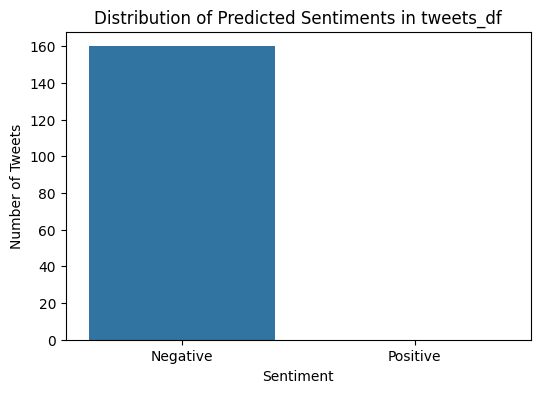

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of predicted sentiments
sentiment_labels = ['Negative', 'Positive']
counts = [sentiment_counts[0], sentiment_counts[1]]

plt.figure(figsize=(6, 4))
sns.barplot(x=sentiment_labels, y=counts)
plt.title('Distribution of Predicted Sentiments in tweets_df')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()